# **Required Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import random

# **Load the Dataset**

In [ ]:
df = pd.read_csv('adult.csv')

In [ ]:
df.head(10)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


In [ ]:
df.isnull().sum()

,0
age,0
workclass,0
fnlwgt,0
education,0
educational-num,0
marital-status,0
occupation,0
relationship,0
race,0
gender,0


# **Preprocess the Dataset**

## **Clean and encode**

In [ ]:
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)

# Encode categorical variables
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

## **Feature scaling**

In [ ]:
# Feature scaling
X = df.drop('income', axis=1)
y = df['income']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## **Split into train and test**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# **Define Fitness Function**

In [ ]:
def evaluate_solution(params):
    lr, alpha, hidden = params
    lr = np.clip(lr, 0.0001, 0.1)
    alpha = np.clip(alpha, 0.0001, 2)
    hidden = int(np.clip(hidden, 10, 200))

    clf = MLPClassifier(hidden_layer_sizes=(hidden,),
                        learning_rate_init=lr,
                        alpha=alpha,
                        max_iter=200,
                        random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

# **ACO Initialization**

In [ ]:
num_ants = 10
iterations = 30
pheromone_evaporation = 0.1
pheromone_boost = 2.0

# Parameter ranges
param_ranges = {
    'lr': (0.0001, 0.1),
    'alpha': (0.0001, 2),
    'hidden': (10, 200)
}

# Pheromone matrices
pheromones = {
    'lr': np.ones(10),
    'alpha': np.ones(10),
    'hidden': np.ones(10)
}

# **Genetic Operators**

In [ ]:
def crossover(p1, p2):
    return [(p1[i] + p2[i]) / 2 for i in range(len(p1))]

def mutate(solution, rate=0.2):
    if random.random() < rate:
        index = random.randint(0, len(solution) - 1)
        if index == 0:
            solution[index] += np.random.uniform(-0.01, 0.01)
        elif index == 1:
            solution[index] += np.random.uniform(-0.1, 0.1)
        else:
            solution[index] += random.randint(-10, 10)
    return solution


# **Build Hybrid ACO + GA Logic**

In [ ]:
def hybrid_aco_ga(num_ants=10, internal_iterations=10):
    global_best = None
    global_best_score = -np.inf
    best_scores = []

    for it in range(internal_iterations):
        solutions = []
        scores = []

        for _ in range(num_ants):
            # Select values based on pheromone
            lr_index = np.random.choice(10, p=pheromones['lr'] / pheromones['lr'].sum())
            alpha_index = np.random.choice(10, p=pheromones['alpha'] / pheromones['alpha'].sum())
            hidden_index = np.random.choice(10, p=pheromones['hidden'] / pheromones['hidden'].sum())

            # Convert index to actual parameter value
            lr = param_ranges['lr'][0] + lr_index * (param_ranges['lr'][1] - param_ranges['lr'][0]) / 10
            alpha = param_ranges['alpha'][0] + alpha_index * (param_ranges['alpha'][1] - param_ranges['alpha'][0]) / 10
            hidden = int(param_ranges['hidden'][0] + hidden_index * (param_ranges['hidden'][1] - param_ranges['hidden'][0]) / 10)

            solution = [lr, alpha, hidden]
            solutions.append(solution)
            scores.append(evaluate_solution(solution))

        # GA crossover and mutation
        children = []
        for _ in range(num_ants // 2):
            parents = random.sample(solutions, 2)
            child = crossover(parents[0], parents[1])
            child = mutate(child)
            children.append(child)
            scores.append(evaluate_solution(child))
            solutions.append(child)

        # Update pheromone trails
        for i, param in enumerate(['lr', 'alpha', 'hidden']):
            pheromones[param] = (1 - pheromone_evaporation) * pheromones[param]
            for sol, score in zip(solutions, scores):
                bin_index = int((sol[i] - param_ranges[param][0]) / ((param_ranges[param][1] - param_ranges[param][0]) / 10))
                bin_index = min(max(bin_index, 0), 9)
                pheromones[param][bin_index] += score * pheromone_boost

        # Update best solution
        best_index = np.argmax(scores)
        if scores[best_index] > global_best_score:
            global_best_score = scores[best_index]
            global_best = solutions[best_index]

        best_scores.append(global_best_score)
        print(f"Iteration {it + 1}: Best Accuracy = {global_best_score:.4f}")

    return global_best, global_best_score, best_scores

# **Run Experiments & Plot Results**

In [ ]:
all_accuracies = []
for i in range(30):  # 30 runs
    print(f"Run {i+1}/30")
    _, acc, score_progress = hybrid_aco_ga()
    all_accuracies.append(acc)

Run 1/30
Iteration 1: Best Accuracy = 0.8489
Iteration 2: Best Accuracy = 0.8489
Iteration 3: Best Accuracy = 0.8489
Iteration 4: Best Accuracy = 0.8501
Iteration 5: Best Accuracy = 0.8501
Iteration 6: Best Accuracy = 0.8512
Iteration 7: Best Accuracy = 0.8512
Iteration 8: Best Accuracy = 0.8512
Iteration 9: Best Accuracy = 0.8512
Iteration 10: Best Accuracy = 0.8512
Run 2/30
Iteration 1: Best Accuracy = 0.8413
Iteration 2: Best Accuracy = 0.8480
Iteration 3: Best Accuracy = 0.8480
Iteration 4: Best Accuracy = 0.8480
Iteration 5: Best Accuracy = 0.8480
Iteration 6: Best Accuracy = 0.8480
Iteration 7: Best Accuracy = 0.8480
Iteration 8: Best Accuracy = 0.8480
Iteration 9: Best Accuracy = 0.8490
Iteration 10: Best Accuracy = 0.8490
Run 3/30
Iteration 1: Best Accuracy = 0.8427
Iteration 2: Best Accuracy = 0.8449
Iteration 3: Best Accuracy = 0.8449
Iteration 4: Best Accuracy = 0.8537
Iteration 5: Best Accuracy = 0.8537
Iteration 6: Best Accuracy = 0.8537
Iteration 7: Best Accuracy = 0.8537

# **Visualization**

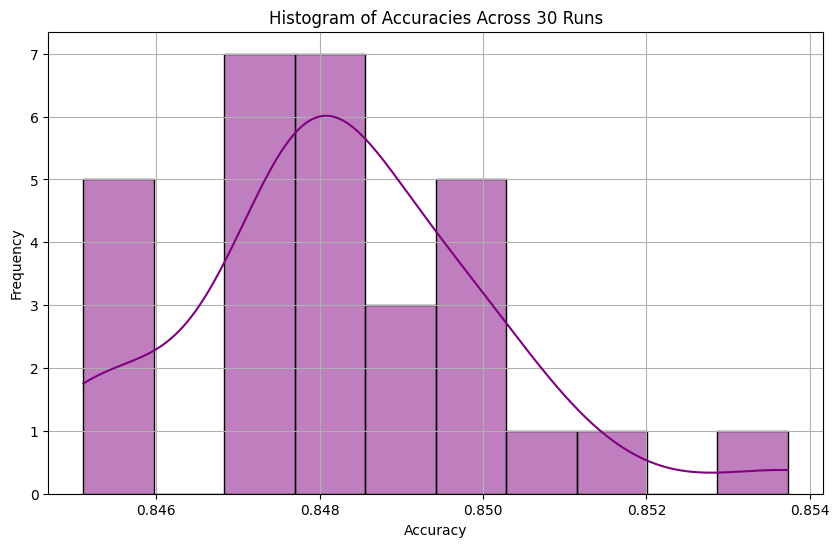

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(all_accuracies, bins=10, kde=True, color='purple')
plt.title("Histogram of Accuracies Across 30 Runs")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
print("Average Accuracy:", np.mean(all_accuracies))
print("Max Accuracy:", np.max(all_accuracies))

Average Accuracy: 0.8482513359130276
Max Accuracy: 0.8537313432835821


# **MLP Classification with Best Parameters**

In [ ]:
# Run the optimizer one final time to get best parameters
best_params, best_acc, _ = hybrid_aco_ga()
lr, alpha, hidden = best_params
hidden = int(hidden)

# Train final classifier with optimal parameters
final_model = MLPClassifier(
    hidden_layer_sizes=(hidden,),
    learning_rate_init=lr,
    alpha=alpha,
    max_iter=300,
    random_state=42
)

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

# Final evaluation
from sklearn.metrics import classification_report, confusion_matrix

print("=== Final Classification Results ===")
print(f"Best Params -> Learning Rate: {lr}, Alpha: {alpha}, Hidden Units: {hidden}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

final_accuracy = accuracy_score(y_test, y_pred)
print(f"Final Accuracy on Test Set: {final_accuracy:.4f}")

Iteration 1: Best Accuracy = 0.8477
Iteration 2: Best Accuracy = 0.8477
Iteration 3: Best Accuracy = 0.8477
Iteration 4: Best Accuracy = 0.8477
Iteration 5: Best Accuracy = 0.8507
Iteration 6: Best Accuracy = 0.8507
Iteration 7: Best Accuracy = 0.8507
Iteration 8: Best Accuracy = 0.8507
Iteration 9: Best Accuracy = 0.8507
Iteration 10: Best Accuracy = 0.8507
=== Final Classification Results ===
Best Params -> Learning Rate: 0.02008, Alpha: 0.0001, Hidden Units: 48
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.90      6842
           1       0.74      0.59      0.66      2203

    accuracy                           0.85      9045
   macro avg       0.81      0.76      0.78      9045
weighted avg       0.84      0.85      0.84      9045

Confusion Matrix:
[[6398  444]
 [ 906 1297]]
Final Accuracy on Test Set: 0.8507
